# Фильтры

In [10]:
import os
from imageio import imread
from skimage.color import rgb2gray
from skimage.filters import try_all_threshold, threshold_isodata, threshold_yen, gaussian, threshold_local
from skimage.measure import label as sk_measure_label
from skimage.morphology import binary_opening, binary_closing
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.measure import regionprops

DATASET_TRUE = "./../dataset/true/"
DATASET_FALSE = "./../dataset/false/"

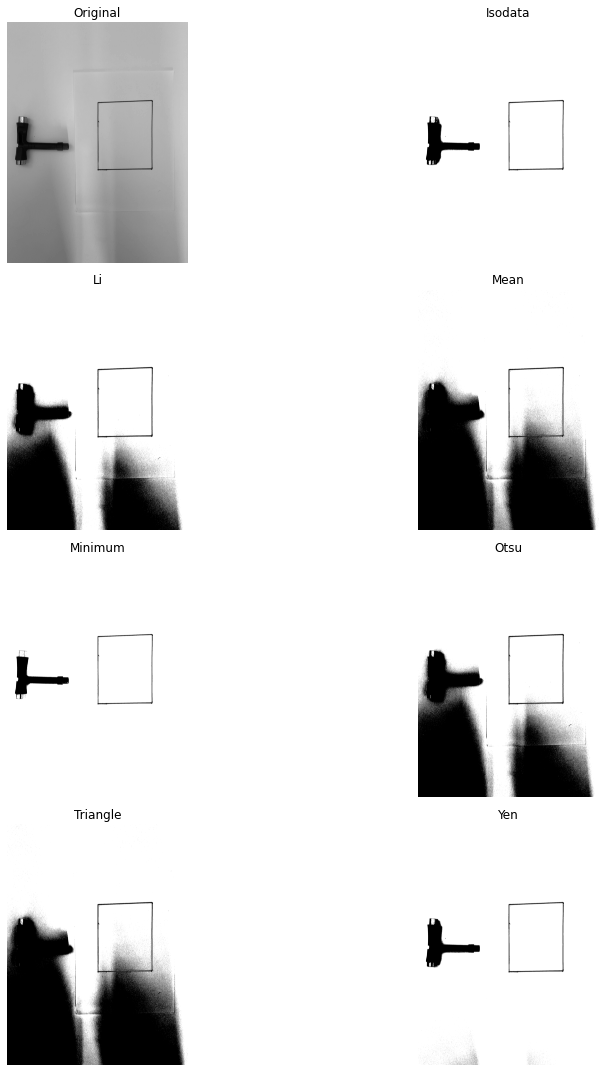

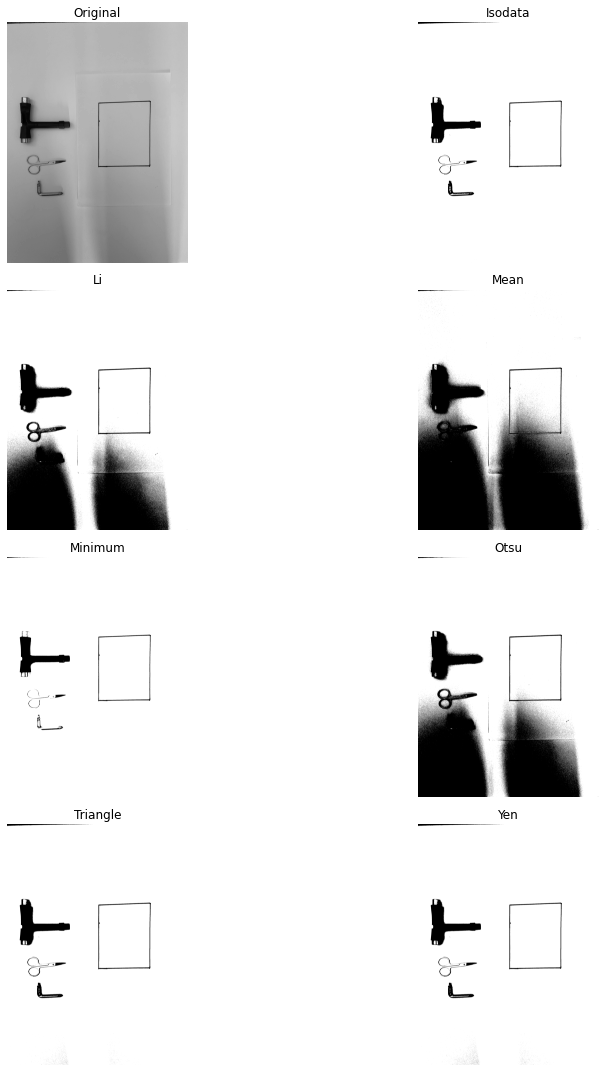

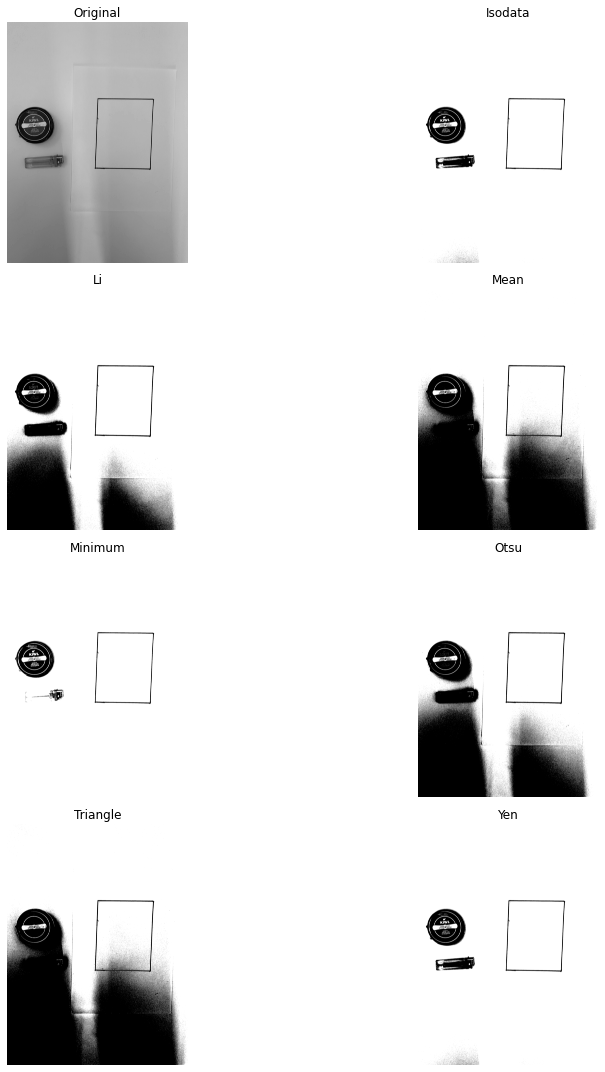

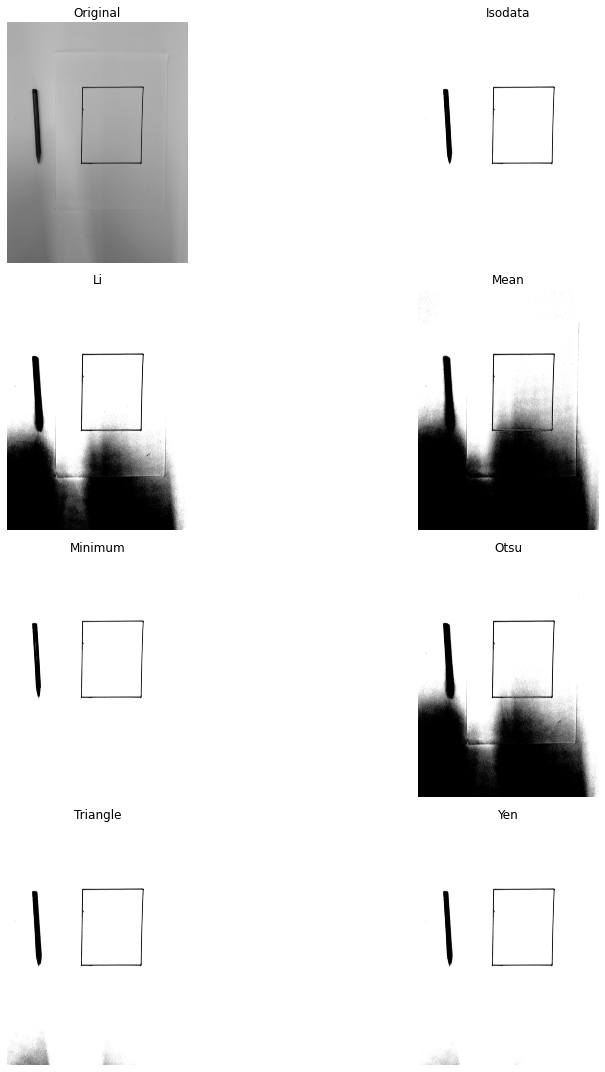

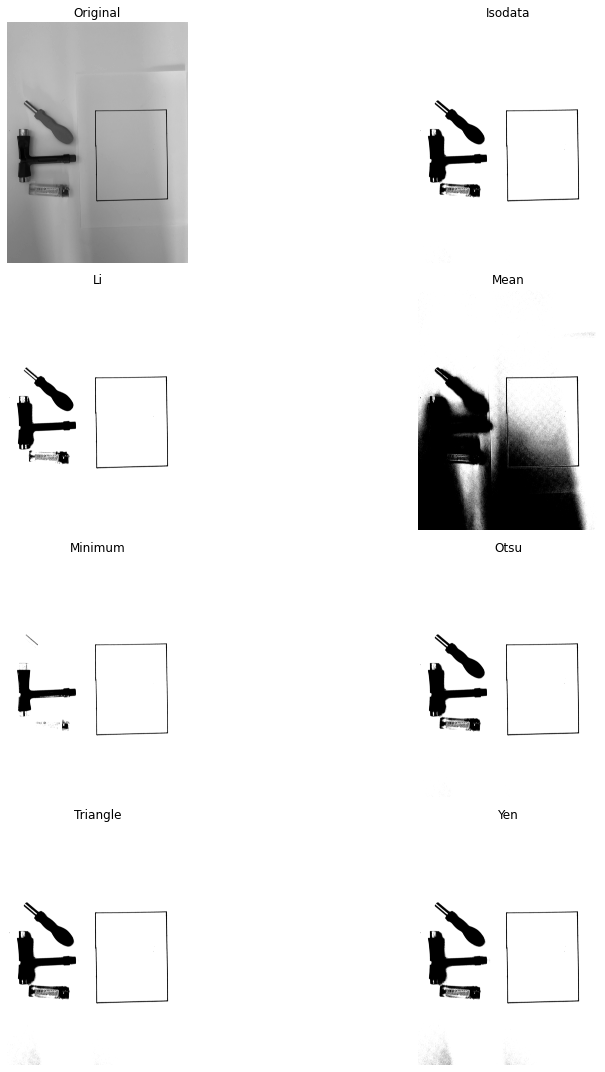

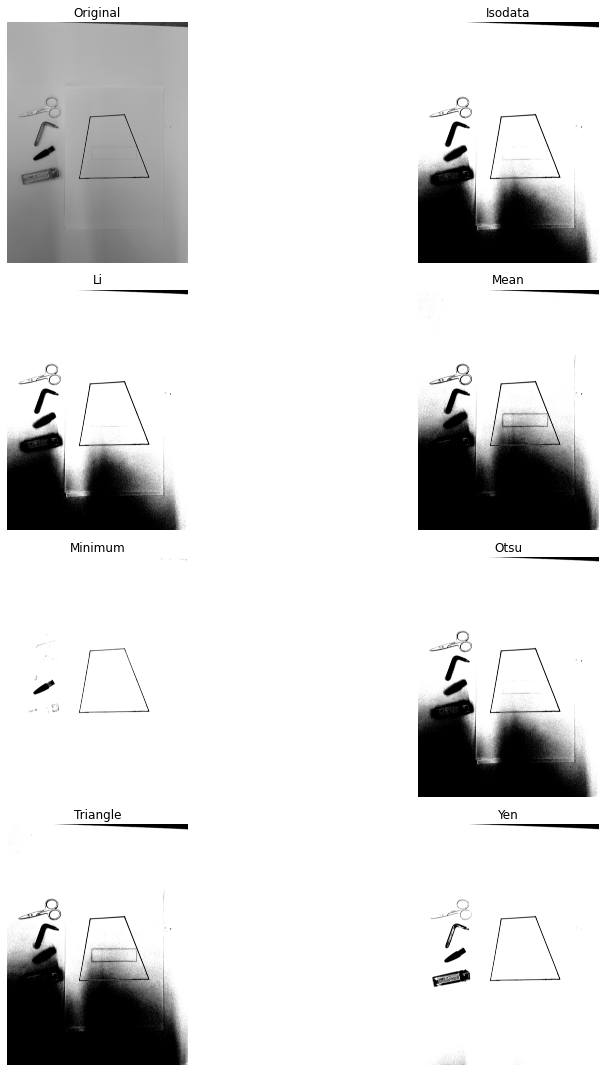

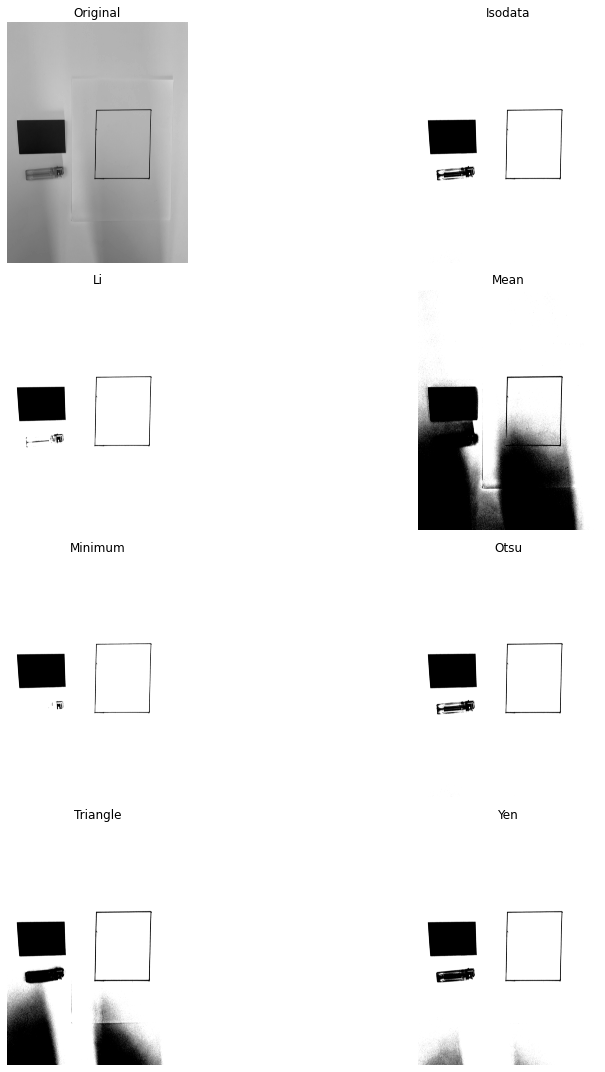

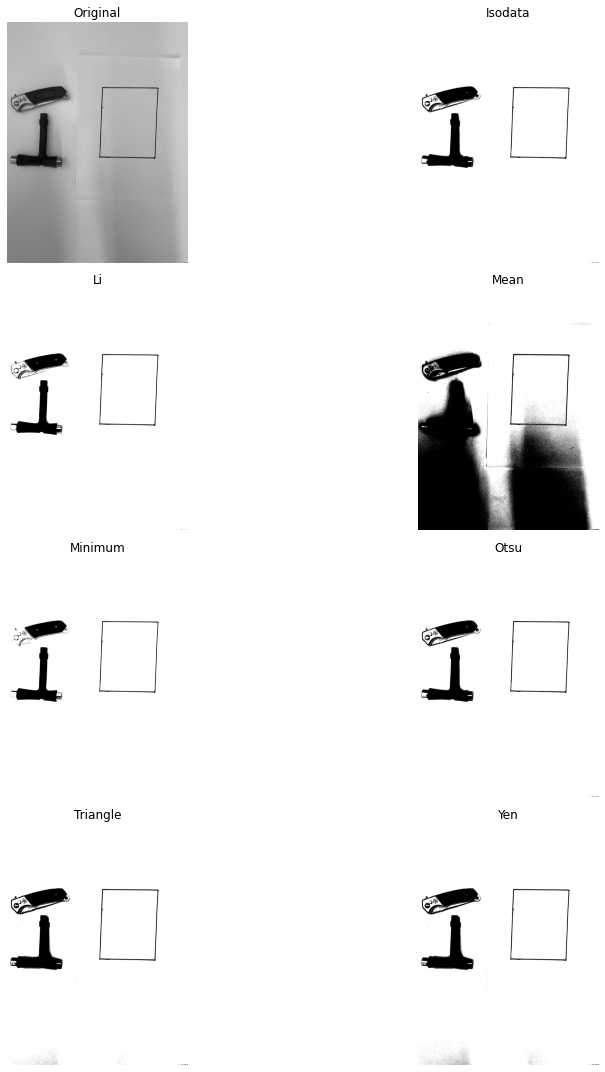

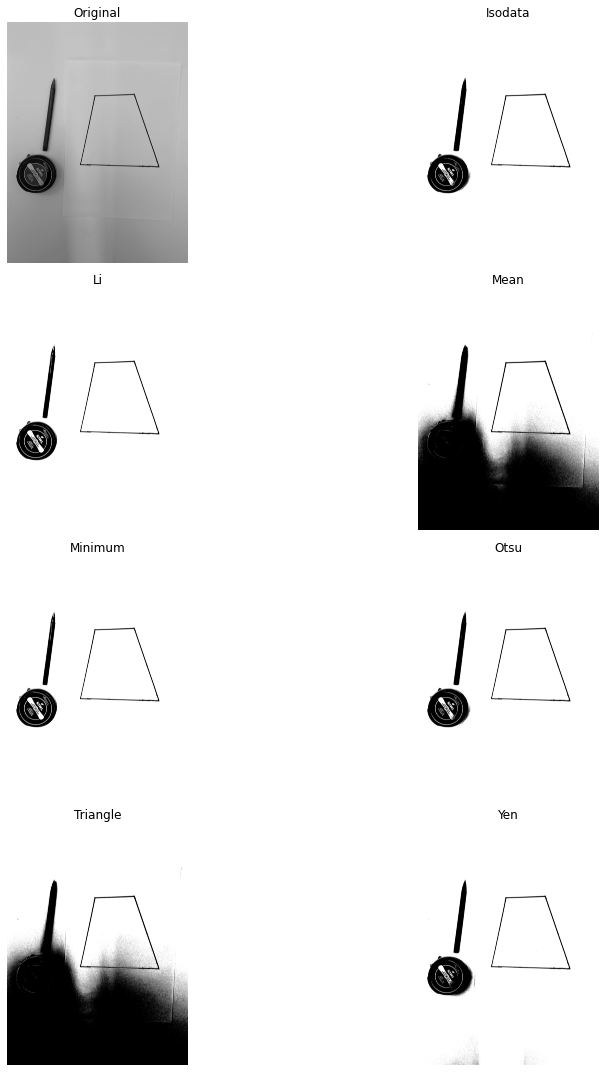

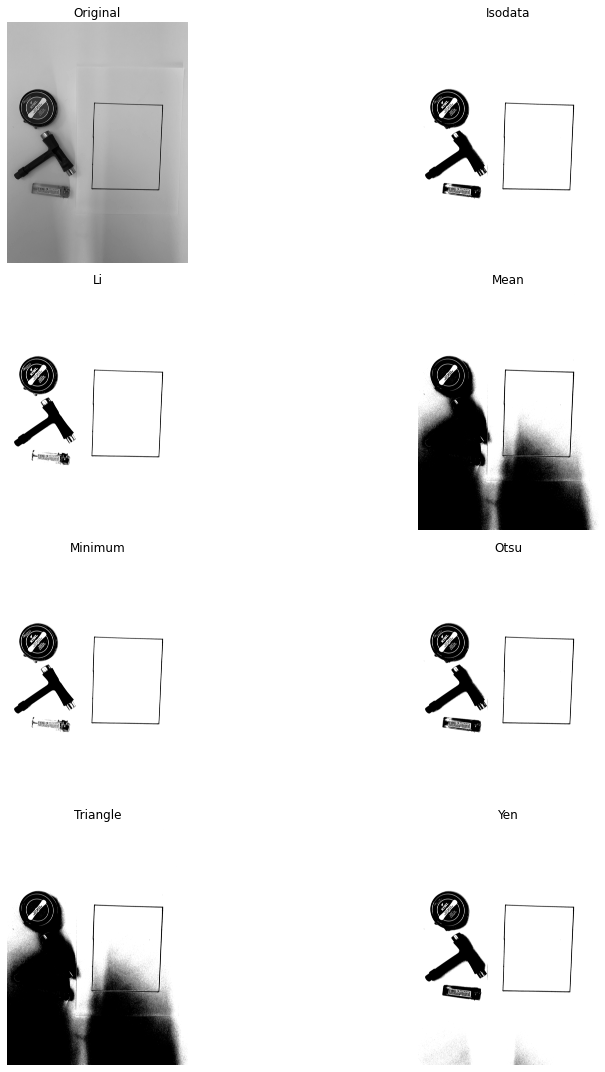

/Users/lev.saskov/opt/anaconda3/lib/python3.9/site-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


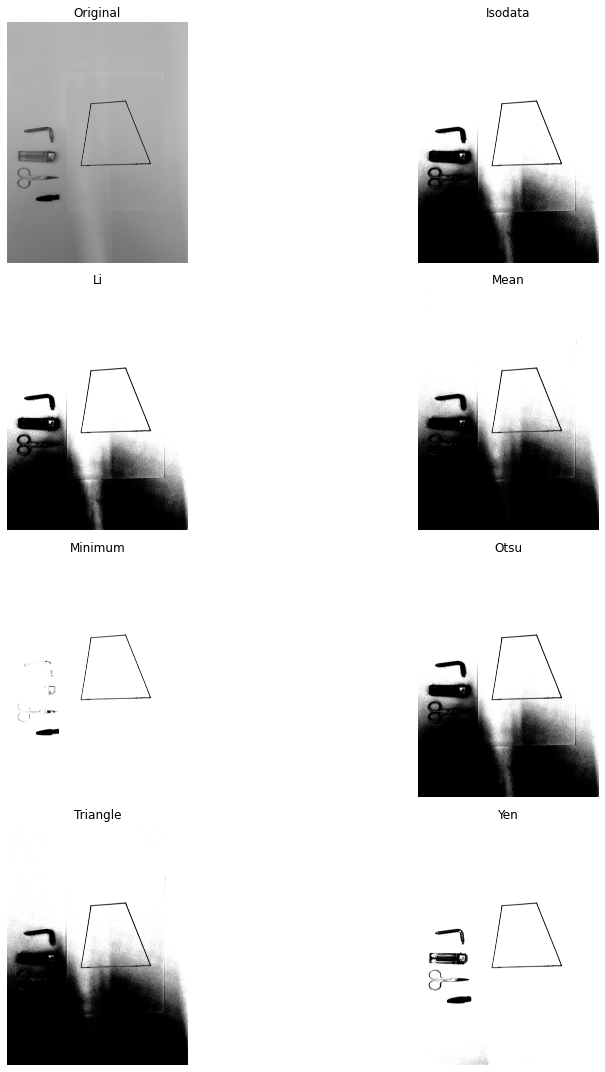

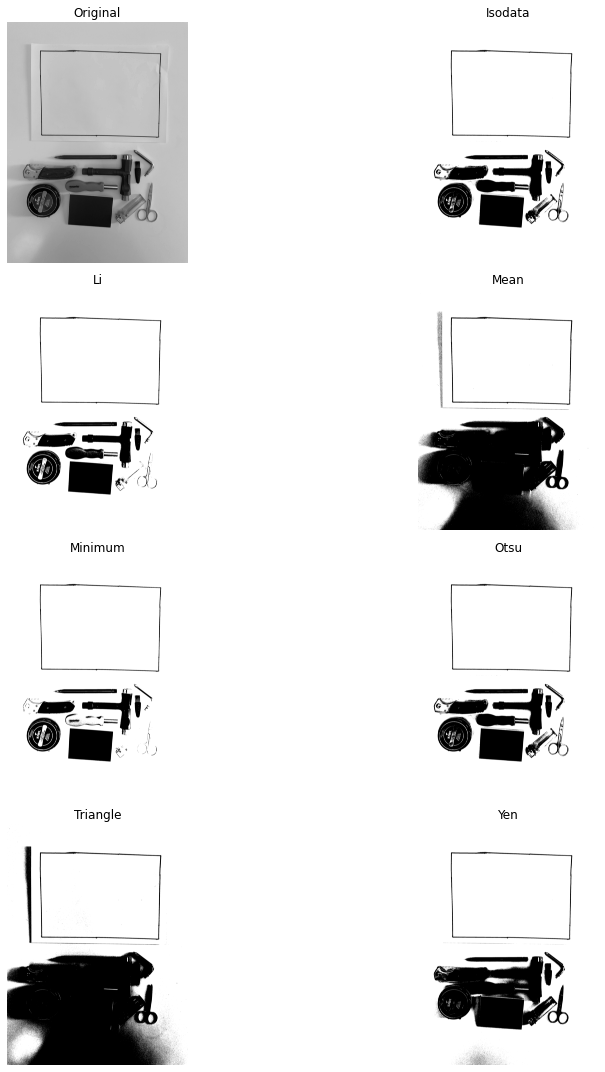

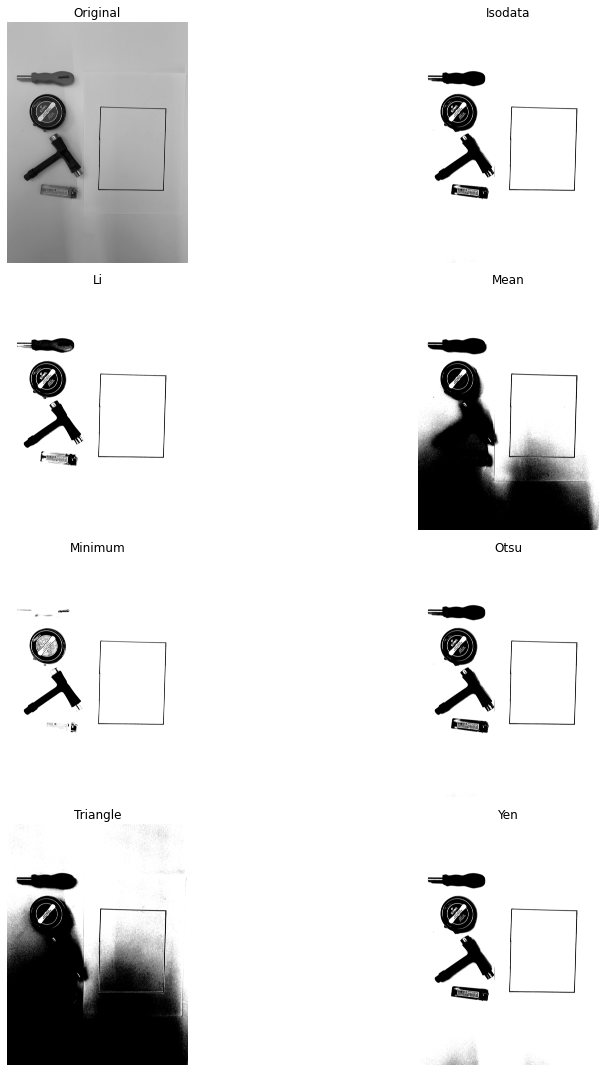

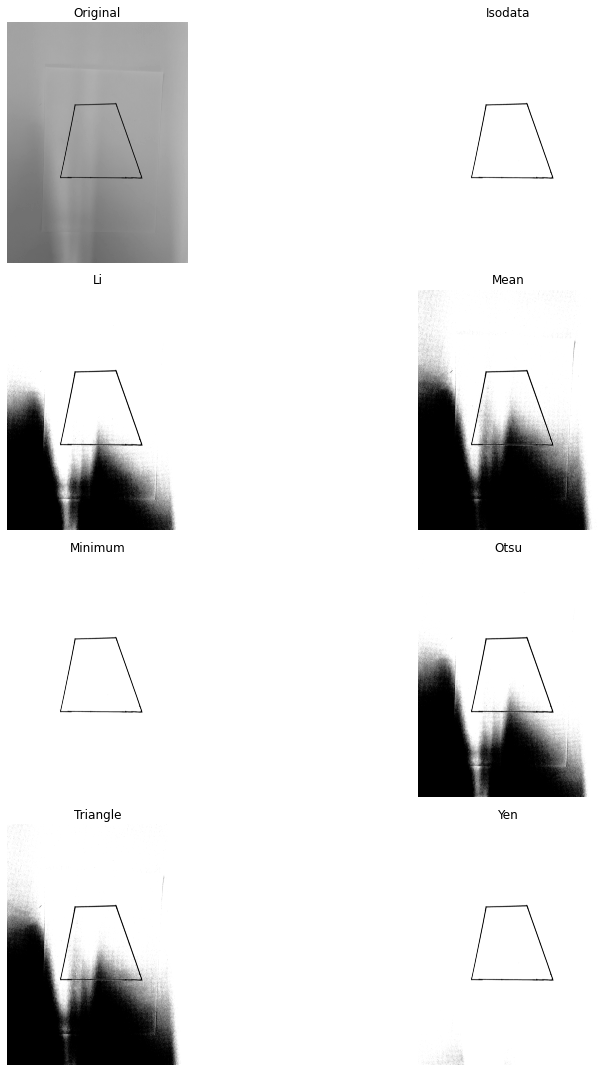

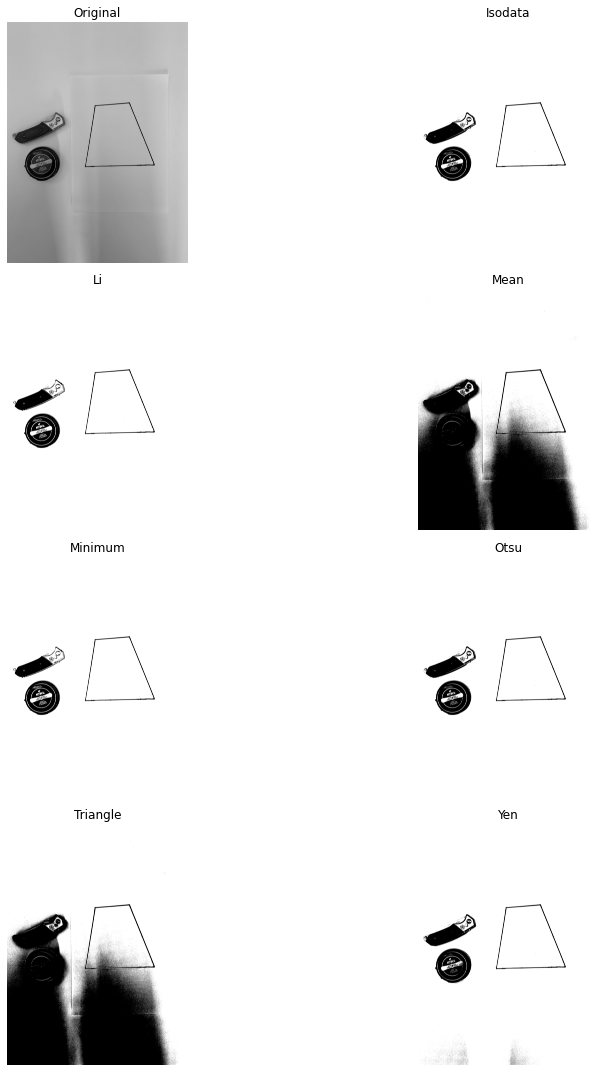

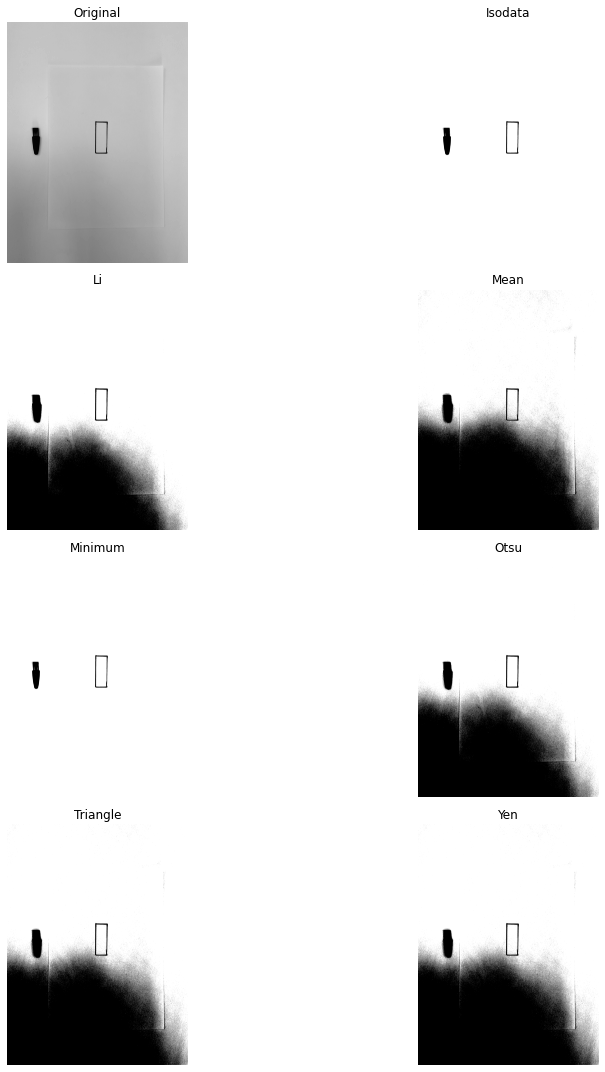

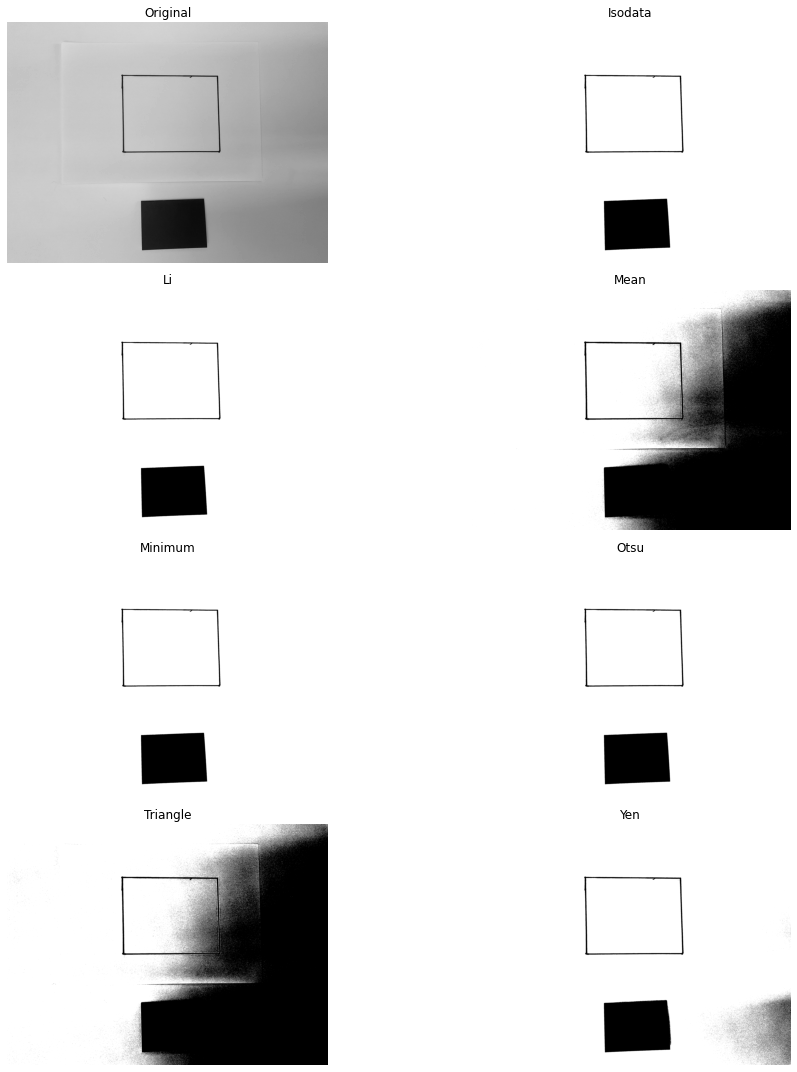

In [21]:
def show_all_filters(picture_name):
    picture = rgb2gray(imread(picture_name))
    fig, ax = try_all_threshold(picture, figsize=(15, 15), verbose=False)
    plt.show()

for picture_name in os.listdir(DATASET_TRUE):
    show_all_filters(os.path.join(DATASET_TRUE, picture_name))

# fig, ax = try_all_threshold(gray_picture, figsize=(15, 15), verbose=False)
# plt.show()

Хорошо себя показывают ISODATA и Yen. Дальше будем работать только с ними.

In [18]:
def get_mask(filename, threshold):
    print(filename)
    blur = gaussian(imread(filename), sigma=1.5, channel_axis=2)
    gray = rgb2gray(blur)
    thresh = threshold(gray)
    mask = gray >= thresh
    return mask

def polish_mask(mask):
    result = binary_closing(mask, footprint=np.ones((10, 10)))
    return binary_opening(result, footprint=np.ones((10, 10)))

def get_components(mask):
    labels = sk_measure_label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    return props

def show_all_masks_in_folder(folder):
    for picture_name in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, picture_name)):
            continue
        mask = polish_mask(get_mask(os.path.join(folder, picture_name), threshold_isodata))
        plt.imshow(mask, cmap='gray')
        plt.title(picture_name)
        plt.show()
        props = get_components(mask)
        # Считая многоугольник
        print("Components count: ", len(props))

True dataset: 


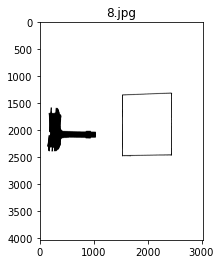

Components count:  2


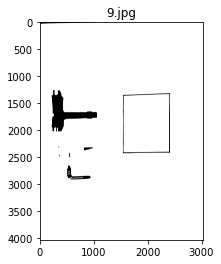

Components count:  4


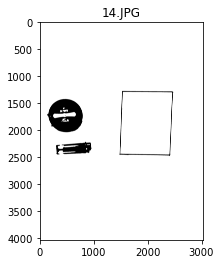

Components count:  13


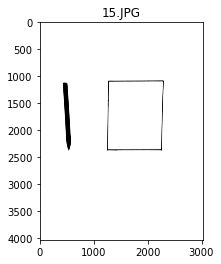

Components count:  2


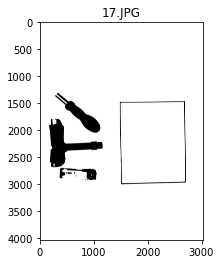

Components count:  4


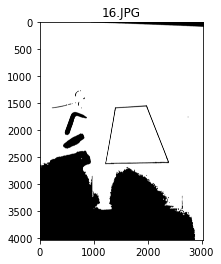

Components count:  17


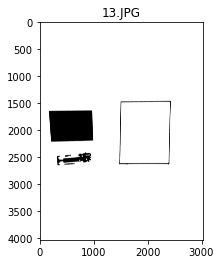

Components count:  6


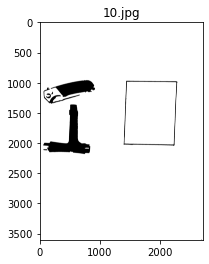

Components count:  3


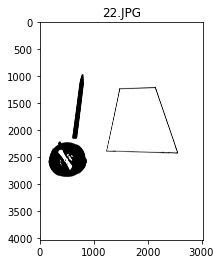

Components count:  10


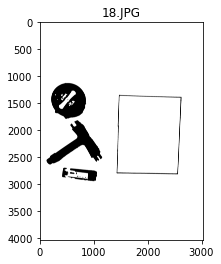

Components count:  10


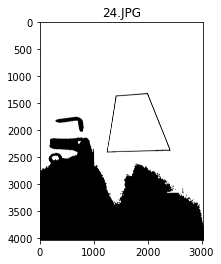

Components count:  17


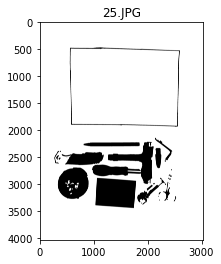

Components count:  16


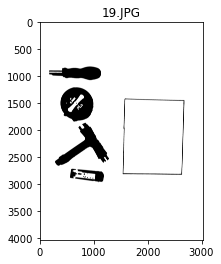

Components count:  9


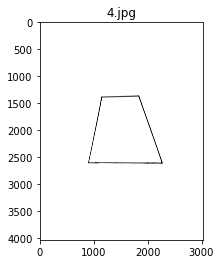

Components count:  2


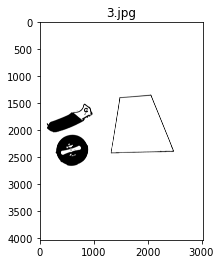

Components count:  11


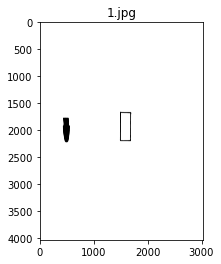

Components count:  2


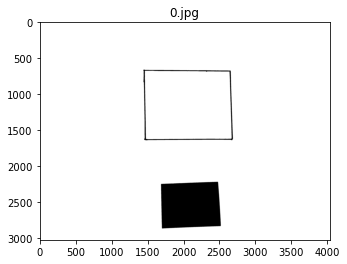

Components count:  2

 False dataset: 


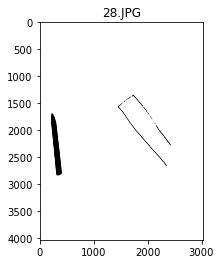

Components count:  1


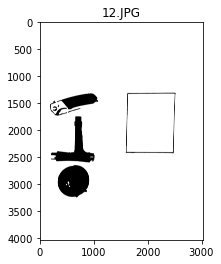

Components count:  8


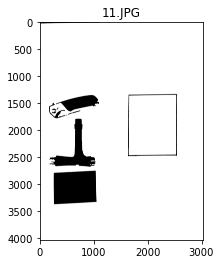

Components count:  4


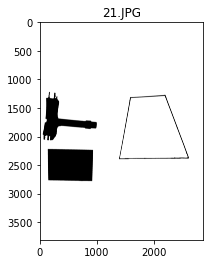

Components count:  2


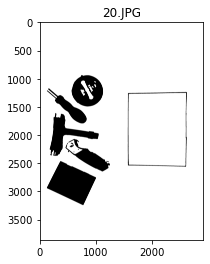

Components count:  9


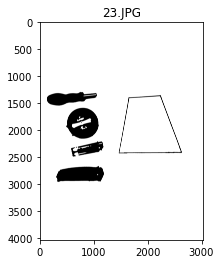

Components count:  16


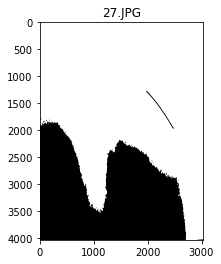

Components count:  10


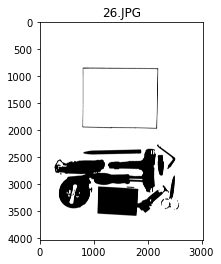

Components count:  17


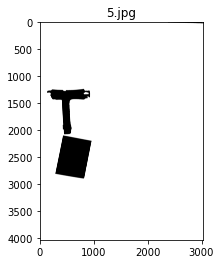

Components count:  3


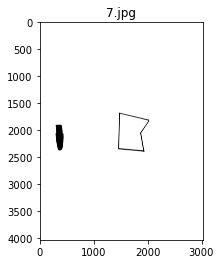

Components count:  2


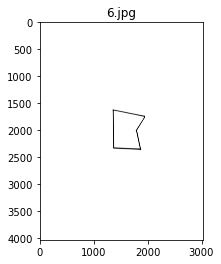

Components count:  2


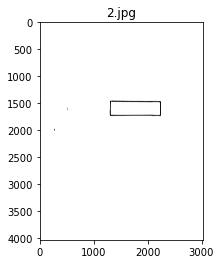

Components count:  2


In [11]:
# print(get_components(os.path.join(DATASET_TRUE, "1.jpg")))
print("True dataset: ")
show_all_masks_in_folder(DATASET_TRUE)

print("\n False dataset: ")
show_all_masks_in_folder(DATASET_FALSE)
# TODO: Закрывать прорехи, Сделать так, чтобы было верное количество компонент связности.
# plt.imshow(get_components(os.path.join(DATASET_TRUE, "3.jpg")))

Проблемные по свету картинки: 16, 24, 27. На них свет слишком не равномерный. Сделаем для них метку light. И поместим в поддиректорию bad, потом может быть захотим улучшить алгоритм и вернуть их в рассмотрение.

Также для удобства работы и дальнейшего переиспользования вынесем функции в пакет masking.py

In [39]:
import masking
import importlib
importlib.reload(masking)


<module 'masking' from '/Users/lev.saskov/MyProgramms/Univercity/intelligent-placer/PlacerProject/masking.py'>

True dataset: 
Getting mask from ./../dataset/true/8.jpg


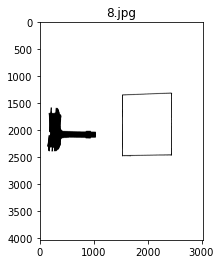

Components count:  2
Getting mask from ./../dataset/true/9.jpg


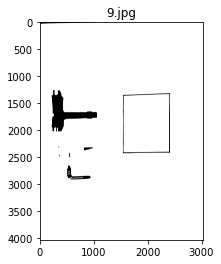

Components count:  4
Getting mask from ./../dataset/true/14.JPG


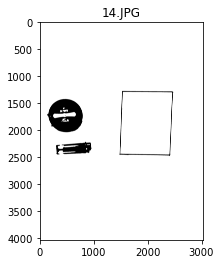

Components count:  13
Getting mask from ./../dataset/true/15.JPG


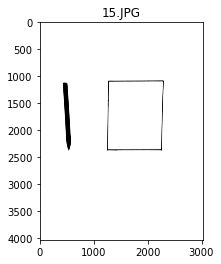

Components count:  2
Getting mask from ./../dataset/true/17.JPG


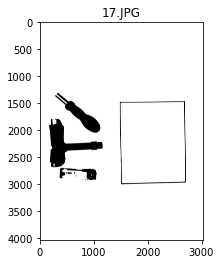

Components count:  4
Skipped  bad
Getting mask from ./../dataset/true/13.JPG


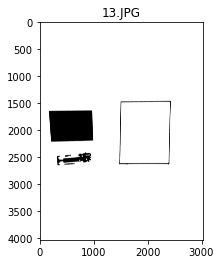

Components count:  6
Getting mask from ./../dataset/true/10.jpg


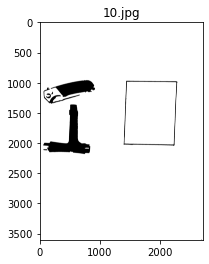

Components count:  3
Getting mask from ./../dataset/true/22.JPG


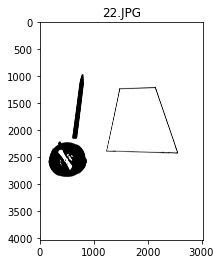

Components count:  10
Getting mask from ./../dataset/true/18.JPG


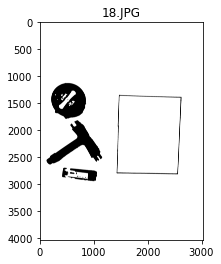

Components count:  10
Getting mask from ./../dataset/true/25.JPG


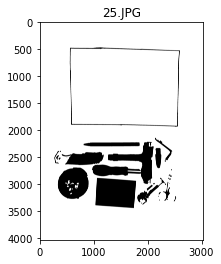

Components count:  16
Getting mask from ./../dataset/true/19.JPG


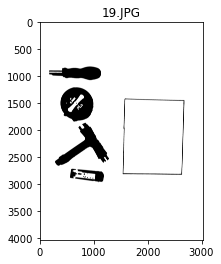

Components count:  9
Getting mask from ./../dataset/true/4.jpg


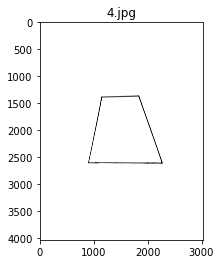

Components count:  2
Getting mask from ./../dataset/true/3.jpg


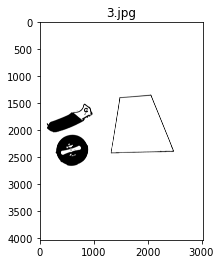

Components count:  11
Getting mask from ./../dataset/true/1.jpg


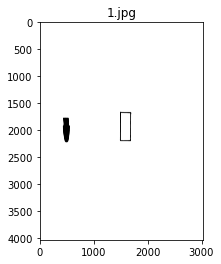

Components count:  2
Getting mask from ./../dataset/true/0.jpg


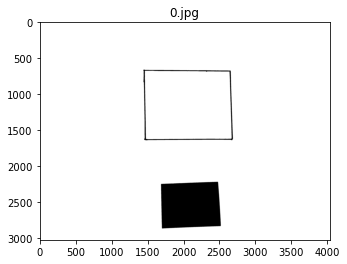

Components count:  2

 False dataset: 
Getting mask from ./../dataset/false/28.JPG


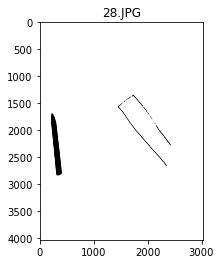

Components count:  1
Skipped  bad
Getting mask from ./../dataset/false/12.JPG


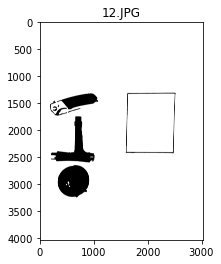

Components count:  8
Getting mask from ./../dataset/false/11.JPG


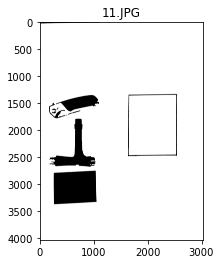

Components count:  4
Getting mask from ./../dataset/false/21.JPG


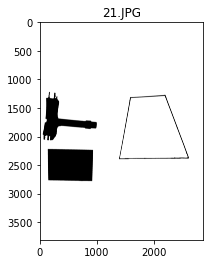

Components count:  2
Getting mask from ./../dataset/false/20.JPG


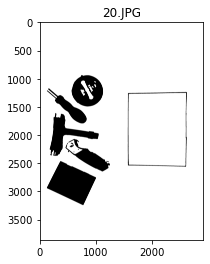

Components count:  9
Getting mask from ./../dataset/false/23.JPG


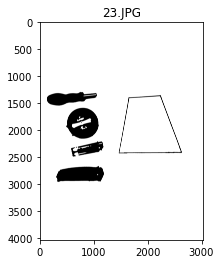

Components count:  16
Getting mask from ./../dataset/false/26.JPG


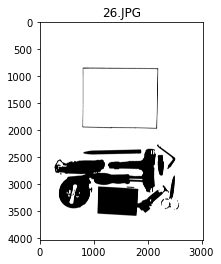

Components count:  17
Getting mask from ./../dataset/false/5.jpg


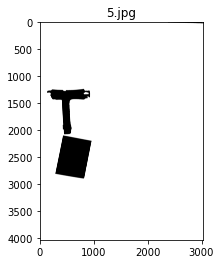

Components count:  3
Getting mask from ./../dataset/false/7.jpg


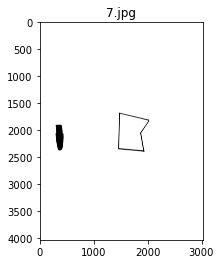

Components count:  2
Getting mask from ./../dataset/false/6.jpg


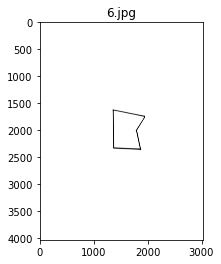

Components count:  2
Getting mask from ./../dataset/false/2.jpg


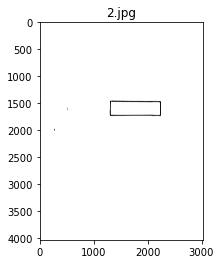

Components count:  2


In [40]:
# Еще раз прогоним захват масок на оставшихся изображениях:
print("True dataset: ")
masking.show_all_masks_in_folder(DATASET_TRUE)

print("\n False dataset: ")
masking.show_all_masks_in_folder(DATASET_FALSE)


Нужно сделать так, чтобы верно находились компоненты связности. Для этого нужно более эффективно закрывать дыры.